In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import os
import kagglehub

In [2]:
path = kagglehub.dataset_download("abeerelmorshedy/fashion-clothes")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/abeerelmorshedy/fashion-clothes/versions/1


In [9]:
def load_smaller_dataset(dataset_path, max_images=1000):
    image_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                image_paths.append(img_path)
                if len(image_paths) >= max_images:  # Stop after reaching max_images
                    break
        if len(image_paths) >= max_images:  # Stop after reaching max_images
            break

    # Load and preprocess images
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(224, 224))  # Resize to 224x224
        img = img_to_array(img)
        images.append(img)
    return np.array(images), image_paths

max_images = 1000  # Adjust this number based on your needs
x_train_resized, image_paths = load_smaller_dataset(path, max_images)

In [10]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [11]:
def extract_features(images, model):
    images = preprocess_input(images)  # Preprocess the images for ResNet50
    features = model.predict(images)  # Extract features using ResNet50
    return features


In [12]:
rain_features = []
batch_size = 32  # Define batch size for processing
for i in range(0, len(x_train_resized), batch_size):
    batch = x_train_resized[i:i + batch_size]
    print(f"Processing batch {i // batch_size + 1} / {len(x_train_resized) // batch_size + 1}")

    # Pass the model as an argument to extract_features
    features = extract_features(batch, model)
    train_features.append(features)

train_features = np.vstack(train_features)  # Combine all features
train_features_reshaped = train_features.reshape(train_features.shape[0], -1)


Processing batch 1 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Processing batch 2 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Processing batch 3 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Processing batch 4 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Processing batch 5 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 6 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Processing batch 7 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 8 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 9 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 10 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Processing batch 11 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 12 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Processing batch 13 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 14 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Processing batch 15 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 16 / 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Processing batch 17 / 32
1/1 ━━━━

In [33]:
def get_similar_images(query_image, top_n=5):
    query_features = extract_features(np.expand_dims(query_image, axis=0), model)  # Pass the model here
    query_features = query_features.reshape(1, -1)

    # Assuming train_features is already computed and available
    sim_scores = cosine_similarity(query_features, train_features_reshaped)  # Similarity calculation
    sim_scores = sim_scores.flatten()

    # Get all valid indices (within the range of image_paths)
    valid_indices = [idx for idx in np.argsort(sim_scores)[::-1] if idx < len(image_paths)]

    # Ensure we return at most top_n indices
    top_indices = valid_indices[:top_n]

    return top_indices, sim_scores


In [34]:
def display_similar_images(query_img_path, top_n=5):
    if not os.path.exists(query_img_path):
        print(f"Error: The file at '{query_img_path}' does not exist.")
        return

    # Load the query image from the input path
    query_img = load_img(query_img_path, target_size=(224, 224))
    query_img = img_to_array(query_img)

    # Get similar images
    top_indices, sim_scores = get_similar_images(query_img, top_n)

    # Plot the query image and the most similar images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(query_img.astype('uint8'))
    plt.title("Query Image")
    plt.axis('off')

    for i, idx in enumerate(top_indices):
        if idx >= len(image_paths):  # Ensure index is within valid range
            print(f"Warning: Index {idx} is out of range for image_paths.")
            continue
        similar_img_path = image_paths[idx]
        similar_img = load_img(similar_img_path, target_size=(224, 224))
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(similar_img)
        plt.title(f"Sim. {i+1}")
        plt.axis('off')

    plt.show()

In [35]:
def run_system():
    print("Welcome to the Clothing Similarity System!")
    while True:
        # Prompt user for an image path
        query_img_path = input("Please provide the path to the image (or type 'exit' to quit): ").strip()

        # Exit condition
        if query_img_path.lower() == 'exit':
            print("Exiting the system. Goodbye!")
            break

        # Display the similar images based on the input image path
        display_similar_images(query_img_path, top_n=5)


Welcome to the Clothing Similarity System!
Please provide the path to the image (or type 'exit' to quit): /content/OIP (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


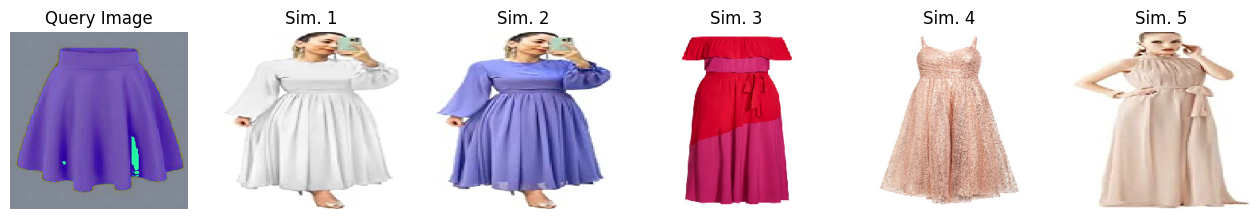

KeyboardInterrupt: Interrupted by user

In [45]:
run_system()